Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems navigate to Edit -> Notebook settings -> Hardware accelerator, set it to GPU, and then click Save.

In [1]:
!nvidia-smi

Thu Sep 28 11:07:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0  On |                  N/A |
| 48%   49C    P5    34W / 370W |    344MiB / 10240MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

NOTE: To make it easier for us to manage datasets, images and models we create a HOME constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test


Install Segment Anything Model (SAM) and other dependencies

In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-9evhxrf7
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-9evhxrf7
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [4]:
%pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

Note: you may need to restart the kernel to use updated packages.


In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test


mkdir: cannot create directory ‘/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test/weights’: File exists
/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test/weights/sam_vit_h_4b8939.pth ; exist: True


In [7]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test
/media/kce-trainer/HDD-06/workspace_palm/image_segmentation/sam_segment_test/data


In [12]:
%pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 15.5 MB/s eta 0:00:00m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [15]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [26]:
import os

IMAGE_NAME = "factory.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [27]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [28]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


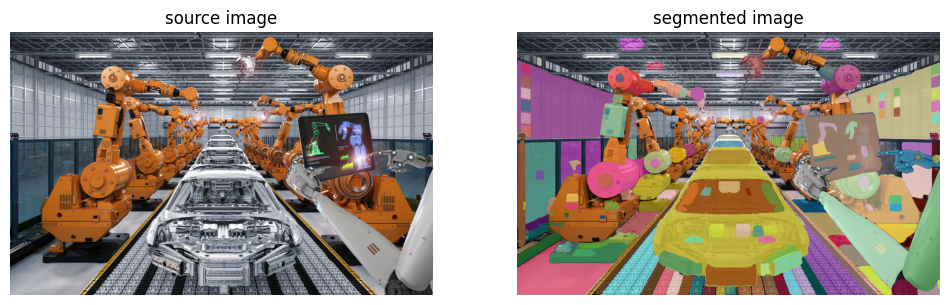

In [29]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [31]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

ValueError: The number of images exceeds the grid size. Please increase the grid size or reduce the number of images.

In [21]:
mask_predictor = SamPredictor(sam)

In [22]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [23]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

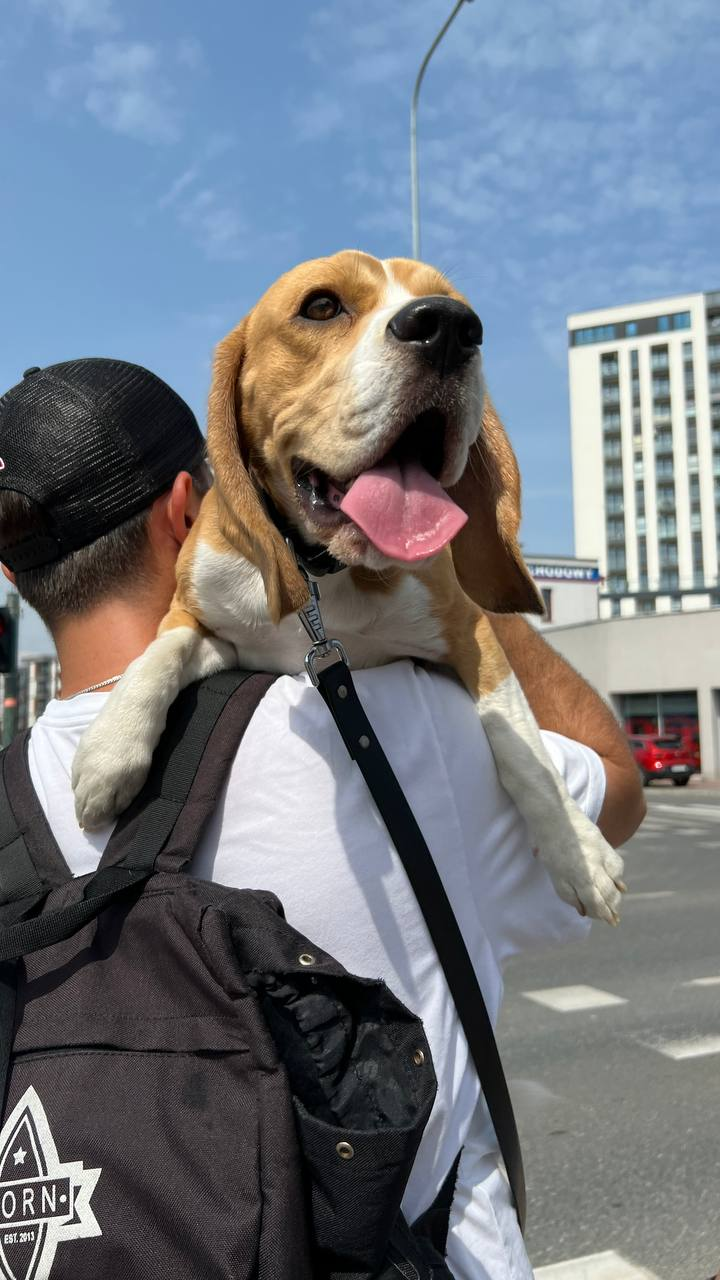

FloatText(value=0.0, description='X:')

In [25]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

# Define a function to display the image
def display_image(image_path):
    img = Image.open(image_path)
    display(img)

# Load your image (replace 'IMAGE_PATH' with the actual path to your image)
display_image(IMAGE_PATH)

# Create a bounding box widget
bbox_widget = widgets.FloatText(value=0.0, description='X:')
display(bbox_widget)

# Define a function to handle bounding box changes
def on_bbox_change(change):
    x = change.new
    # You can perform actions based on the bounding box coordinates here
    print(f'Bounding Box X-coordinate: {x}')

# Attach the bounding box widget to the function
bbox_widget.observe(on_bbox_change, names='value')
